In [1]:
# # # unQuote to install dependency
# !pip3 install matplotlib
# !pip3 install numpy

# # # unQuote to install dependency
# # # for Nvidia gpu / cpu version  # I didn't try with ROCm for AMD gpu (pytorch.org) if you want to look at it
# update nvidia driver
# download and install cuda from : https://developer.nvidia.com/cuda-11-6-1-download-archive
# install cudnn :  https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

# # # unQuote to install dependency
# # # for cpu only | the model is fairly small for cartpole for exampe, so it should be able to run well on cpu only
# !pip3 install torch torchvision torchaudio

# # # unQuote to install dependency
# # # Gym env for game simulation
# !pip3 install Box2D
# !pip3 install box2d-py
# !pip3 install gym[all]
# !pip3 install gym[Box_2D]
# !pip3 install gym[box2d]

##### OR #####
# # replace  " !pip3 "  by " !pip " depending on the OS



#PHASE 1 :
#TODO: Make pytest function
#TODO: Delete copy.deepcopy() in self play , with reset function
#TODO: fix the report (opt)
#TODO: Fix comment all over the code (opt)
#TODO: Board configuration and Atari configuration
#TODO: fix onehot encode function ( it's ugly ) or generalize one hot with his counter part going for 1 to 4d with path:: can t (opt)
#TODO: multi worker for simulation and multi worker for training cpu/gpu. check for multi remote worker on aws/gcloud/asure . 
#TODO: add model search parameter

In [1]:
import gym

from monte_carlo_tree_search import *
from game import *
from replay_buffer import *
from muzero_model import *
from self_play import *

# # # unquote to print tensor completly
# torch.set_printoptions(profile="full")
# np.set_printoptions(threshold=np.inf)



In [2]:
# # # set game environment from gym library
env = gym.make('CartPole-v1') # 77min to solve carpole

# # # the random seed are set to 0 for reproducibility purpose
# # # good reference about it at : https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(0) # set the random seed of numpy
torch.manual_seed(0) # set the random seed of pytorch
env.seed(0) # set the random seed of gym env

# # # init/set muzero model for training and inference
muzero = Muzero(model_structure = 'mlp_model', # 'vision_model' : will use rgb as observation , 'mlp_model' : will use game state as observation
                observation_space_dimensions = env.observation_space, # dimension of the observation 
                action_space_dimensions = env.action_space, # dimension of the action allow (gym box/discrete)
                state_space_dimensions= 10, # support size / encoding space
                hidden_layer_dimensions = 256, # number of weight in the recursive layer of the mlp
                number_of_hidden_layer= 5, # number of recusion layer of hidden layer of the mlp
                k_hypothetical_steps= 10, # number of future step you want to be simulate during train (they are mainly support loss)
                learning_rate= 0.01, # learning rate of the optimizer
                num_of_epoch = 10000, # number of step during training (the number of step of self play and training can be change)
                device="cpu", # device on which you want the comput to be made : "cpu" , "cuda:0" , "cuda:1" , etc
                type_format = torch.float32, # choice the dtype of the model. look at [https://pytorch.org/docs/1.8.1/amp.html#ops-that-can-autocast-to-float16]
                load = False, # function for loading a save model
                use_amp = False, # use mix precision for gpu (not implement yet)
                scaler_on = False, # scale gradient to reduce computation
                bin_method = "uniform_bin", # "linear_bin" , "uniform_bin" : will have a regular incrementation of action or uniform sampling(pick randomly) from the bound
                bin_decomposition_number = 10) # number of action to sample from low/high bound of a gym discret box

# # # init/set the game storage(stor each game) and dataset(create dataset) generate during training
replay_buffer = ReplayBuffer(window_size = 500, # number of game store in the buffer
                             batch_size = 128, # batch size is the number of observe game during train
                             num_unroll = muzero.k_hypothetical_steps, # number of mouve/play store inside the batched game
                             td_steps = 50, # number of step the value is scale on 
                             game_sampling = "uniform", # 'uniform' or "priority" (will game randomly or with a priority distribution)
                             position_sampling = "uniform") # 'uniform' or "priority" (will sample position in game randomly or with a priority distribution)

# # # init/set the monte carlos tree search parameter
mcts = Monte_carlo_tree_search(pb_c_base=19652 , 
                               pb_c_init=1.25, 
                               discount= 0.95, 
                               root_dirichlet_alpha=0.25, 
                               root_exploration_fraction=0.25)

# # # ini/set the Game class which embbed the gym game class function
gameplay = Game(gym_env = env, 
                discount = 0.997,
                limit_of_game_play = float("inf"), # maximum number of mouve
                observation_dimension = muzero.observation_dimension, 
                action_dimension = muzero.action_dimension,
                rgb_observation = muzero.is_RGB,
                action_map = muzero.action_dictionnary)


print( muzero.observation_dimension, muzero.action_dimension)



4 2


In [3]:
# # # train model (if you choice vison model it will render the game)
epoch_pr , loss , reward = learning_cycle(number_of_iteration = 1000, # number of epoch(step) in  muzero should be the |total amount of number_of_iteration x number_of_training_before_self_play|
                                          number_of_self_play_before_training = 5, # number of game played record in the replay buffer before training
                                          number_of_training_before_self_play = 5, # number of epoch made by the model before selplay
                                          number_of_mcts_simulation = 11, 
                                          model_tag_number = 123, # tag number use to generate checkpoint
                                          verbose = True, # if you want to print the epoch|reward|loss during train
                                          muzero_model = muzero,
                                          gameplay = gameplay,
                                          number_of_monte_carlo_tree_search = mcts,
                                          replay_buffer = replay_buffer)


EPOCH 1 || reward: 9.0 || loss: 5779.78173828125||
EPOCH 2 || reward: 10.0 || loss: 3803.17578125||
EPOCH 3 || reward: 10.0 || loss: 3827.905517578125||
EPOCH 4 || reward: 9.0 || loss: 4003.935546875||
EPOCH 5 || reward: 10.0 || loss: 4004.4921875||
EPOCH 6 || reward: 9.0 || loss: 3857.43505859375||
EPOCH 7 || reward: 9.0 || loss: 3744.87646484375||
EPOCH 8 || reward: 139.2 || loss: 4144.1943359375||
EPOCH 9 || reward: 21.0 || loss: 4450.2900390625||
EPOCH 10 || reward: 19.0 || loss: 4465.1123046875||
EPOCH 11 || reward: 21.0 || loss: 4535.1962890625||
EPOCH 12 || reward: 14.0 || loss: 4685.5478515625||
EPOCH 13 || reward: 14.0 || loss: 4540.408203125||
EPOCH 14 || reward: 9.0 || loss: 4466.611328125||
EPOCH 15 || reward: 11.0 || loss: 4650.1650390625||
EPOCH 16 || reward: 12.0 || loss: 4472.02294921875||
EPOCH 17 || reward: 12.0 || loss: 4633.77099609375||
EPOCH 18 || reward: 11.0 || loss: 4723.4697265625||
EPOCH 19 || reward: 10.0 || loss: 4550.4951171875||
EPOCH 20 || reward: 9.0 ||

KeyboardInterrupt: 

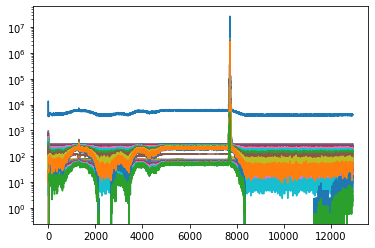

In [5]:
# # # little report in .txt file and save last model weight
# # # model is already save during training with an associate TAG
import random
import matplotlib.pyplot as plt
import sys
import time

t = time.localtime()
current_time = time.strftime("%H_%M_%S", t)
q = random.randint(1,1000000000000)

with open(f'res/{q}_{current_time}_model_weight_printed.txt', "a+") as f:
    print("observation_space_dimensions",muzero.observation_dimension, file=f) 
    print("action_space_dimensions: ",muzero.action_dimension,  file=f)
    print("state_space_dimensions: ",muzero.state_dimension, file=f) 
    print("k_hypothetical_steps: ",muzero.k_hypothetical_steps,  file=f)
    print("learning_rate: ",muzero.lr, file=f)
    print("device: ",muzero.device, file=f)
    print("num_of_epoch: ",muzero.epoch, file=f)
    print("hidden_layer_dimensions: ",muzero.hidden_layer_dimension,  file=f)
    print("number_of_hidden_layer: ",muzero.number_of_hidden_layer, file=f)
    print("window_size: ",replay_buffer.window_size,  file=f)
    print("batch_size: ",replay_buffer.batch_size, file=f)
    print("num_unroll: ",replay_buffer.num_unroll,  file=f)
    print("td_steps: ",replay_buffer.td_steps, file=f)
    print("||||||||||||||||||||||||||||||||", file=f)
    print("||||||||||||||||||||||||||||||||", file=f)
    print("||||||||||||||||||||||||||||||||", file=f)
    print("  ", file=f)
    print("  ", file=f)
    print("  ", file=f)
    print("|||||||||||||| START MODEL <representation_function> ||||||||||||||", file=f)
    for i in muzero.representation_function.parameters():
        print(i,i.size(), file=f)
    print("|||||||||||||| END MODEL <representation_function> ||||||||||||||||", file=f)
    print("|||||||||||||||||||||||||||||||||||||||||||||||||", file=f)
    print("|||||||||||||| START MODEL <dynamics_function> ||||||||||||||||||||", file=f)
    for i in muzero.dynamics_function.parameters():
        print(i,i.size(), file=f)
    print("|||||||||||||| END MODEL <dynamics_function> ||||||||||||||||||||||", file=f)
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||", file=f)
    print("|||||||||||||| START MODEL <prediction_function> ||||||||||||||||||", file=f)
    for i in muzero.prediction_function.parameters():
        print(i,i.size(), file=f)
    print("|||||||||||||| END MODEL <prediction_function> ||||||||||||||||||||", file=f)
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||", file=f)
    for i in epoch_pr:
        print(i, file=f)
        


torch.save(muzero.representation_function, f'res/{q}_{current_time}_muzero_rp.pt')
torch.save(muzero.dynamics_function, f'res/{q}_{current_time}_muzero_dy.pt')
torch.save(muzero.prediction_function, f'res/{q}_{current_time}_muzero_pr.pt')

plt.plot(reward)
plt.savefig(f'res/{q}_{current_time}_reward.png')
plt.figure()
plt.yscale('log')


all_loss=np.array([np.array([a.cpu().detach() for a in x[:]]) for x in muzero.store_loss])
plt.plot(all_loss)

plt.savefig(f'res/{q}_{current_time}_training.png')


In [1]:
from self_play import play_game_from_checkpoint
import torch 

play_game_from_checkpoint(game_to_play = 'CartPole-v1',
                            
                          model_tag = 124,
                          model_device = "cpu",
                          model_type = torch.float32,
                            
                          mcts_pb_c_base=19652 , 
                          mcts_pb_c_init=1.25, 
                          mcts_discount= 0.95, 
                          mcts_root_dirichlet_alpha=0.25, 
                          mcts_root_exploration_fraction=0.25,
                          mcts_with_or_without_dirichlet_noise = True,
                          number_of_monte_carlo_tree_search_simulation = 11,
                            
                          gameplay_discount = 0.997,
                            
                          temperature = 0,
                          game_iter = 2000,
                            
                          slow_mo_in_second = 0.0,
                          render = True,
                          verbose = True)

Mouve number: 1 , Action: 1, Policy: [0. 1.]
Mouve number: 2 , Action: 0, Policy: [1. 0.]
Mouve number: 3 , Action: 0, Policy: [1. 0.]
Mouve number: 4 , Action: 1, Policy: [0. 1.]
Mouve number: 5 , Action: 0, Policy: [1. 0.]
Mouve number: 6 , Action: 1, Policy: [0. 1.]
Mouve number: 7 , Action: 0, Policy: [1. 0.]
Mouve number: 8 , Action: 1, Policy: [0. 1.]
Mouve number: 9 , Action: 0, Policy: [1. 0.]
Mouve number: 10 , Action: 1, Policy: [0. 1.]
Mouve number: 11 , Action: 0, Policy: [1. 0.]
Mouve number: 12 , Action: 1, Policy: [0. 1.]
Mouve number: 13 , Action: 0, Policy: [1. 0.]
Mouve number: 14 , Action: 1, Policy: [0. 1.]
Mouve number: 15 , Action: 0, Policy: [1. 0.]
Mouve number: 16 , Action: 1, Policy: [0. 1.]
Mouve number: 17 , Action: 0, Policy: [1. 0.]
Mouve number: 18 , Action: 1, Policy: [0. 1.]
Mouve number: 19 , Action: 0, Policy: [1. 0.]
Mouve number: 20 , Action: 1, Policy: [0. 1.]
Mouve number: 21 , Action: 0, Policy: [1. 0.]
Mouve number: 22 , Action: 1, Policy: [0. 1

In [ ]:
# Under this cell you will find a manual script to train and play game if you need it

In [ ]:


# # # # Training
# number_of_iteration = muzero.epoch
# reward , cache_reward , epoch_pr, loss , cache_loss  = [] , [] , [] , [] , []
# number_of_self_play_before_training = 1
# number_of_training_before_self_play = 1
# number_of_mcts_simulation = 11
# for ep in range(1,number_of_iteration+1):
    
#     # # # reset the cache reward for every iteration
#     cache_reward = []
#     cache_loss = []
    
#     # # # self_play
#     for self_play in range(number_of_self_play_before_training):
#         # # # run game with mcts prediction and run step from the policy output 
#         game = play_game(environment = gameplay, 
#                          model = muzero,
#                          monte_carlo_tree_search = mcts , 
#                          number_of_monte_carlo_tree_search_simulation = number_of_mcts_simulation,
#                          temperature = temperature_scheduler(number_of_iteration+1,ep),
#                         ) 
#         # # # save all the necessary parameter during play_game fortraining
#         replay_buffer.save_game(game)
#         # # # save the cumulative reward of each self_play
#         cache_reward.append(sum(game.rewards))
#     # # # sum the average reward of all self_play
#     reward.append(sum(cache_reward)/len(cache_reward))
    
#     # # # save best model. self_play serve as dataset and performace test
#     if reward[-1] == max(reward):
#         muzero.save_model(directory = "result", tag= 124)
    
#     # # # train model from all game accumulate in the buffer (of the replay_buffer)
#     for i in range(number_of_training_before_self_play):
#         muzero.train(replay_buffer.sample_batch())
#         cache_loss.append(muzero.store_loss[-1][0])
#     loss.append(sum(cache_loss)/len(cache_loss))
#     prompt_feedback = f'EPOCH {ep} || reward: {reward[-1]} || loss: { loss[-1] }||'
#     epoch_pr.append(prompt_feedback)
#     print(prompt_feedback)
    

In [ ]:
# #play with model of choice

# import gym
# import time 

# from monte_carlo_tree_search import *
# from game import *
# from muzero_model import *
# from self_play import *

# # # # choice game env
# # env = gym.make('LunarLander-v2')
# env = gym.make('CartPole-v1')

# # # # initialize model class without initializing a neural network
# muzero = Muzero(load=True, 
#                 type_format = torch.float32)

# # # # load save model with tag number
# muzero.load_model(tag=124,
#                   observation_space_dimensions = env.observation_space, 
#                   device="cuda:0") # set device for model compute

# # # # init the mcts class
# monte_carlo_tree_search = Monte_carlo_tree_search(pb_c_base=19652 , 
#                                                     pb_c_init=1.25, 
#                                                     discount= 0.95, 
#                                                     root_dirichlet_alpha=0.25, 
#                                                     root_exploration_fraction=0.25)

# # # # create the game class with gameplay/record function
# gameplay = Game(env, 
#                 discount = 0.997,
#                 observation_dimension = muzero.observation_dimension, 
#                 action_dimension = muzero.action_dimension,
#                 rgb_observation = muzero.is_RGB,
#                 action_map = muzero.action_dictionnary)

# # # # slow animation of the render ( in second )
# sleep = 0.0

# # # # number of simulation for the monte carlos tree search
# number_of_monte_carlo_tree_search_simulation = 11

# # # # temperature set to 0 will use argmax as policy (highest probability action)
# # # # over a temperature of 0.0035 it will sample with the propability associate to the mouve , picking uniformly
# temperature = 0

# # # # number of iteration (mouve play during the game)
# game_iter = 2000

# environment = copy.deepcopy(gameplay)
# observation_reward_done_info = None

# # # # or while not environment.terminal: # for loop to bypass env terminal limit, else use while loop and add a counter variable incrementing
# for counter in range(game_iter):
    
#     #render the env
#     environment.vision()
    
#     # # #laps time to see a slow motion of the env
#     time.sleep(sleep)
    
#     # # # start the game and get game initial observation / game return observation after action
#     state = environment.observation(iteration = counter,
#                                     feedback = observation_reward_done_info)
    
#     # # # run monte carlos tree search inference
#     # # Train [False or True] mean with or without dirichlet at the root
#     mcts = copy.deepcopy(monte_carlo_tree_search)
#     policy,tree,action = mcts.run(observation = state, 
#                                   model = muzero, 
#                                   num_simulations= number_of_monte_carlo_tree_search_simulation,
#                                   train=False)
    
#     # # # select the best action from policy and inject the action into the game (.step())
#     observation_reward_done_info = environment.policy_step(policy = policy, 
#                                                            action = action,
#                                                            temperature =  temperature)
    
#     # # # reset mcts class to empty cache variable
#     mcts.reset()
    
#     # # # print the number of mouve, action and policy
#     print(f"Mouve number: {counter+1} , Action: {muzero.action_dictionnary[action[np.argmax(policy/policy.sum())]]}, Policy: {policy/policy.sum()}")
# environment.close()

